In [1]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
%matplotlib inline

In [95]:
class RotMNIST(torchvision.datasets.MNIST):
    def __init__(self,*args, max_rotation=2*np.pi, **kwargs):
        super().__init__(*args,download=True,**kwargs)
        N = len(self.data)
        angles = torch.rand(N)* 2 * max_rotation - max_rotation
        with torch.no_grad():
            # Build affine matrices for random rotation of each image
            affineMatrices = torch.zeros(N,2,3)
            affineMatrices[:,0,0] = angles.cos()
            affineMatrices[:,1,1] = angles.cos()
            affineMatrices[:,0,1] = angles.sin()
            affineMatrices[:,1,0] = -angles.sin()
            self.data = self.data.unsqueeze(1).float()
            flowgrid = F.affine_grid(affineMatrices, size = self.data.size())
            self.data = F.grid_sample(self.data, flowgrid)
        self.shuffled_idcs = np.arange(N)
        np.random.shuffle(self.shuffled_idcs)
        # Number of targets: (10 + 2 - 1 choose 2) = 55
        self.tgts2tgt = {}
        k = 0
        for i in range(10):
            for j in range(i,10):
                self.tgts2tgt[(i,j)] = k
                k += 1

    def __getitem__(self, idx):
        idx2 = self.shuffled_idcs[idx]
        im1, im2 = self.data[idx], self.data[idx2]
        im = torch.cat((im1, im2), -1)
        targ1, targ2 = int(self.targets[idx]), int(self.targets[idx2])
        target = self.tgts2tgt[(min(targ1, targ2), max(targ1, targ2))]
        return im, target

    def __len__(self):
        return len(self.data)

In [96]:
dset = RotMNIST("/scr/ayz/pt_datasets", train=True)

Number of targets: 55


Text(0.5, 1.0, 'Target: 51')

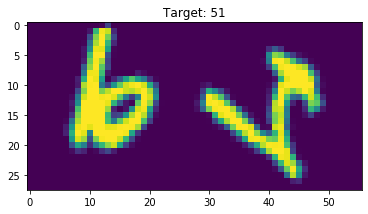

In [86]:
im, target = dset[np.random.randint(60000)]
img = im.numpy().squeeze(0)
plt.imshow(img)
plt.title(f"Target: {target}")

In [87]:
loader = DataLoader(dset, batch_size=32, shuffle=True)

In [89]:
x, y = next(iter(loader))

In [90]:
x.shape

torch.Size([32, 1, 28, 56])

In [92]:
y

tensor([48, 14, 39, 41, 12,  0, 26, 31, 48, 51, 27, 18, 30,  3, 39, 16,  0, 17,
        28, 39, 41, 23, 46,  3, 48, 42,  8,  8, 26, 14,  4, 35])